## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.8]
redice_lr_patient = [5, 10]

In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5


W0808 14:40:55.519211  7280 deprecation.py:323] From C:\Python\V3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
__________

50000/50000 [==============================] - 8s 159us/step - loss: 1.3591 - acc: 0.5282 - val_loss: 1.5582 - val_acc: 0.4539
Epoch 14/25
50000/50000 [==============================] - 7s 145us/step - loss: 1.3397 - acc: 0.5370 - val_loss: 1.5537 - val_acc: 0.4533
Epoch 15/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.3204 - acc: 0.5451 - val_loss: 1.5398 - val_acc: 0.4599
Epoch 16/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.3018 - acc: 0.5515 - val_loss: 1.5340 - val_acc: 0.4630
Epoch 17/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.2828 - acc: 0.5591 - val_loss: 1.5251 - val_acc: 0.4666
Epoch 18/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.2656 - acc: 0.5660 - val_loss: 1.5274 - val_acc: 0.4643
Epoch 19/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.2503 - acc: 0.5698 - val_loss: 1.5247 - val_acc: 0.4667
Epoch 20/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 141us/step - loss: 2.4485 - acc: 0.2195 - val_loss: 2.2251 - val_acc: 0.2770
Epoch 2/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.8939 - acc: 0.3494 - val_loss: 1.9321 - val_acc: 0.3518
Epoch 3/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.7437 - acc: 0.3933 - val_loss: 1.8085 - val_acc: 0.3774
Epoch 4/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.6609 - acc: 0.4214 - val_loss: 1.7360 - val_acc: 0.4008
Epoch 5/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.6024 - acc: 0.4416 - val_loss: 1.6838 - val_acc: 0.4067
Epoch 6/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.5558 - acc: 0.4573 - val_loss: 1.6511 - val_acc: 0.4226
Epoch 7/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.5166 - acc: 0.4701 - val_loss: 1.6210 - 

50000/50000 [==============================] - 7s 143us/step - loss: 0.5088 - acc: 0.8475 - val_loss: 1.4964 - val_acc: 0.5207
Epoch 23/25
50000/50000 [==============================] - 7s 136us/step - loss: 0.4858 - acc: 0.8577 - val_loss: 1.5224 - val_acc: 0.5138
Epoch 24/25
50000/50000 [==============================] - 7s 141us/step - loss: 0.4681 - acc: 0.8666 - val_loss: 1.5188 - val_acc: 0.5205
Epoch 25/25
50000/50000 [==============================] - 7s 137us/step - loss: 0.4540 - acc: 0.8714 - val_loss: 1.5487 - val_acc: 0.5209
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
b

Epoch 9/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.1233 - acc: 0.6162 - val_loss: 1.4751 - val_acc: 0.4771
Epoch 10/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.0916 - acc: 0.6278 - val_loss: 1.4677 - val_acc: 0.4835
Epoch 11/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.0599 - acc: 0.6388 - val_loss: 1.4377 - val_acc: 0.4900
Epoch 12/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.0325 - acc: 0.6514 - val_loss: 1.4408 - val_acc: 0.4874
Epoch 13/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.0030 - acc: 0.6629 - val_loss: 1.4994 - val_acc: 0.4758
Epoch 14/25
50000/50000 [==============================] - 7s 141us/step - loss: 0.9772 - acc: 0.6724 - val_loss: 1.4373 - val_acc: 0.5018
Epoch 15/25
50000/50000 [==============================] - 7s 138us/step - loss: 0.9523 - acc: 0.6815 - val_loss: 1.4455 - val_acc: 0.4980
Epoch 16/25
50000/50000 [===

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 173us/step - loss: 1.7906 - acc: 0.3747 - val_loss: 2.0859 - val_acc: 0.3054
Epoch 2/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.5251 - acc: 0.4591 - val_loss: 1.8624 - val_acc: 0.3530
Epoch 3/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.4212 - acc: 0.4973 - val_loss: 5.5637 - val_acc: 0.1723
Epoch 4/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.3431 - acc: 0.5239 - val_loss: 1.9011 - val_acc: 0.3680
Epoch 5/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.2850 - acc: 0.5434 - val_loss: 2.2676 - val_acc: 0.2758
Epoch 6/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.2399 - acc: 0.5603 - val_loss: 1.8237 - val_acc: 0.3824
Epoch 7/25
50000/50000 [==============================] - 7s 144us/step - loss: 1.1998 - acc: 0.5762 - val_loss: 1.9740 - 


Epoch 00022: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 23/25
50000/50000 [==============================] - 7s 149us/step - loss: 0.6293 - acc: 0.8036 - val_loss: 1.5493 - val_acc: 0.4925
Epoch 24/25
50000/50000 [==============================] - 7s 145us/step - loss: 0.6001 - acc: 0.8155 - val_loss: 1.5753 - val_acc: 0.4954
Epoch 25/25
50000/50000 [==============================] - 7s 147us/step - loss: 0.5775 - acc: 0.8245 - val_loss: 1.4676 - val_acc: 0.5134
Numbers of exp: 10, reduce_factor: 0.80, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_34 (Batc (None, 512)       

50000/50000 [==============================] - 7s 143us/step - loss: 1.2697 - acc: 0.5633 - val_loss: 1.5850 - val_acc: 0.4486
Epoch 9/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.2275 - acc: 0.5772 - val_loss: 1.5183 - val_acc: 0.4711
Epoch 10/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.1926 - acc: 0.5910 - val_loss: 1.5840 - val_acc: 0.4481
Epoch 11/25
50000/50000 [==============================] - 7s 144us/step - loss: 1.1561 - acc: 0.6047 - val_loss: 1.5542 - val_acc: 0.4678
Epoch 12/25
50000/50000 [==============================] - 7s 145us/step - loss: 1.1259 - acc: 0.6163 - val_loss: 1.5126 - val_acc: 0.4732
Epoch 13/25
50000/50000 [==============================] - 7s 143us/step - loss: 1.0946 - acc: 0.6261 - val_loss: 1.5686 - val_acc: 0.4606
Epoch 14/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.0677 - acc: 0.6392 - val_loss: 1.6377 - val_acc: 0.4338
Epoch 15/25
50000/50000 [===============

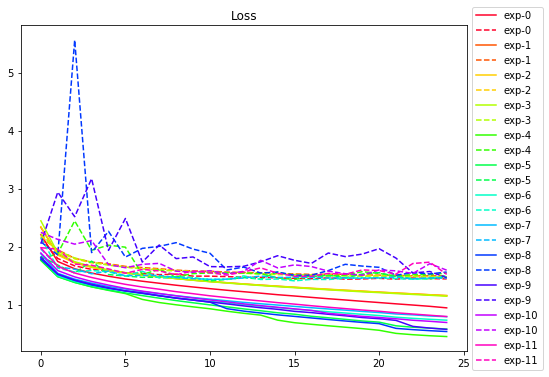

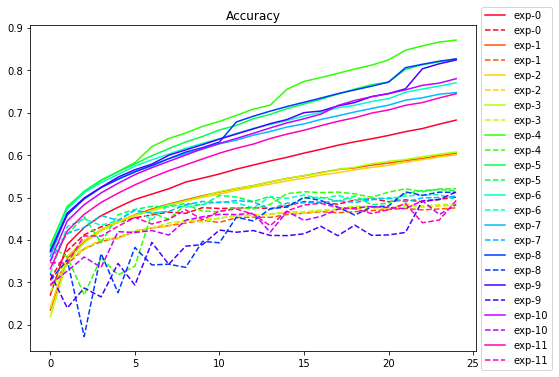

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()